In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical

from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import *

In [0]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [0]:
cd /content/gdrive/My\ Drive/Digikala

/content/gdrive/My Drive/Digikala


In [0]:
df = pd.read_csv('Copy_of_classified_3.csv')

In [0]:
X = df['comment']
y = df['class']

In [0]:
# train = pd.read_csv('balance_classified_train.csv')
# valid = pd.read_csv('balance_classified_valid.csv')

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (14) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [0]:
# train_x = train['comment']
# valid_x = valid['comment']
# train_y = train['target']
# valid_y = valid['target']

In [0]:
from keras.utils import to_categorical
y_binary = to_categorical(y)

# train_y = to_categorical(train_y)
# valid_y = to_categorical(valid_y)

Using TensorFlow backend.


In [0]:
# Split train data into train and validation
train_x, valid_x, train_y, valid_y = train_test_split(X, y_binary, test_size=0.3)

In [0]:
train_labels = train_y
valid_labels = valid_y

In [0]:
print(train_x.shape, valid_x.shape)
print(train_y.shape, valid_y.shape)

(83101,) (35615,)
(83101, 4) (35615, 4)


In [0]:
vocab_size = 10000
embedding_dim = 60
max_length = 120
trunc_type='post'

In [0]:
from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing.text import Tokenizer

tokenizer = Tokenizer(num_words = 50)
tokenizer.fit_on_texts(train_x)
word_index = tokenizer.word_index

train_sequences = tokenizer.texts_to_sequences(train_x)
valid_sequences = tokenizer.texts_to_sequences(valid_x)

In [0]:
# get only the top frequent words on train
train_data = pad_sequences(train_sequences, padding = "post", maxlen = max_length)
# get only the top frequent words on test
valid_data = pad_sequences(valid_sequences, padding = "post", maxlen = max_length)

In [0]:
print(train_data.shape, valid_data.shape)

(83101, 30) (35615, 30)


In [0]:
train_data_reshaped = np.array(train_data).reshape((train_data.shape[0], train_data.shape[1], 1))
valid_data_reshaped = np.array(valid_data).reshape((valid_data.shape[0], valid_data.shape[1], 1))

In [0]:
print(train_data_reshaped.shape, valid_data_reshaped.shape)

(83101, 30, 1) (35615, 30, 1)


In [0]:
train_y_reshaped = np.array(train_y).reshape((train_y.shape[0], train_y.shape[1], 1))
valid_y_reshaped = np.array(valid_y).reshape((valid_y.shape[0], valid_y.shape[1], 1))

In [0]:
print(train_y_reshaped.shape, valid_y_reshaped.shape)

(83101, 4, 1) (35615, 4, 1)


In [0]:
print(train_data.shape)
print(valid_data.shape)
print(train_y.shape)
print(valid_y.shape)

(83101, 30)
(35615, 30)
(83101, 4)
(35615, 4)


In [0]:
from keras.layers import  Concatenate, Permute, Dot, Input, multiply, LSTM, GRU, TimeDistributed
from keras.layers import RepeatVector, Dense, Conv1D, BatchNormalization, MaxPooling1D, Flatten, Dropout, Embedding, Activation, Lambda, Reshape
from keras.layers import *
from keras.layers.advanced_activations import LeakyReLU ,regularizers
from keras.models import Model
from keras.models import Sequential
from keras.optimizers import Adam
from keras.utils import to_categorical
from keras.utils import plot_model
from keras.models import load_model, Model
import keras.backend as K
import numpy as np


In [0]:
#Attention Class
class Attention(Model):
    def __init__(self, units):
        super(Attention, self).__init__()
        self.W1 =Dense(units)
        self.W2 = Dense(units)
        self.V = Dense(1)
 
    def call(self, features, hidden):
        hidden_with_time_axis = expand_dims(hidden, 1)
        score = nn.tanh(self.W1(features) + self.W2(hidden_with_time_axis))
        attention_weights = nn.softmax(self.V(score), axis=1)
        context_vector = attention_weights * features
        context_vector = reduce_sum(context_vector, axis=1)
 
        return context_vector, attention_weights

#Attention function
def Att1_layer(output, units):
    attention = Dense(embedding_dim)(output)
    attention = Permute((2,1))(attention)
    attention = Activation('softmax', name='attention_vec')(attention)
    attention = Permute((2,1))(attention)
    attention = Lambda(lambda x: K.mean(x,axis=2), name='attention', output_shape=(int(output.shape[1]),))(attention)
    attention = RepeatVector(units)(attention)
    attention = Permute((2,1))(attention)
    output = multiply([output,attention])

    return output

 #Attention2 function
def Att2_layer(output, units):
    attention = Dense(1, activation='tanh')(output)
    attention = Flatten()(attention)
    attention = Activation('softmax', name='attention_vec2')(attention)
    attention = RepeatVector(units)(attention)
    attention = Permute([2, 1])(attention)    
    attention = multiply([output,attention])

    return attention        

 #Attention3 function
def Att3_layer(output, units):
    attention = TimeDistributed(Dense(1, activation='tanh'))(output) 
    attention = Flatten()(attention)
    attention = Activation('softmax', name='attention_vec3')(attention)
    attention = RepeatVector(units)(attention)
    attention = Permute([2, 1])(attention) 

    attention = multiply([activations, attention])
    attention = Lambda(lambda xin: K.sum(xin, axis=1))(attention)
    return attention    

##Attentional GRU

In [0]:
units = 250

#GRU Layer
sequence_input = Input(shape=(max_length,))
embedded_sequences = Embedding(vocab_size, embedding_dim, input_length=max_length)(sequence_input)
activations = GRU(units, return_sequences=True)(embedded_sequences)

#Attention Layer
attention = Att3_layer(activations,units)

#GRU Layer
output = Dense(4, activation='softmax')(attention)

model2 = Model(inputs=sequence_input, outputs=output)
model2.summary()

Model: "model_28"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_37 (InputLayer)           (None, 120)          0                                            
__________________________________________________________________________________________________
embedding_37 (Embedding)        (None, 120, 60)      600000      input_37[0][0]                   
__________________________________________________________________________________________________
gru_3 (GRU)                     (None, 120, 250)     233250      embedding_37[0][0]               
__________________________________________________________________________________________________
time_distributed_2 (TimeDistrib (None, 120, 1)       251         gru_3[0][0]                      
___________________________________________________________________________________________

In [0]:
model2.compile(loss = 'categorical_crossentropy', optimizer= 'Adam', metrics = ['accuracy'])

In [0]:
history = model2.fit(train_data, train_labels, epochs=10, batch_size=512, validation_data = (valid_data, valid_labels), verbose=1)

Train on 83101 samples, validate on 35615 samples
Epoch 1/10
83101/83101 [==============================] - 45s 539us/step - loss: 1.3809 - acc: 0.2803 - val_loss: 1.3757 - val_acc: 0.2913
Epoch 2/10
83101/83101 [==============================] - 39s 472us/step - loss: 1.3726 - acc: 0.2982 - val_loss: 1.3724 - val_acc: 0.2967
Epoch 3/10
83101/83101 [==============================] - 39s 471us/step - loss: 1.3704 - acc: 0.3027 - val_loss: 1.3727 - val_acc: 0.2994
Epoch 4/10
83101/83101 [==============================] - 40s 477us/step - loss: 1.3699 - acc: 0.3033 - val_loss: 1.3707 - val_acc: 0.2997
Epoch 5/10
83101/83101 [==============================] - 39s 470us/step - loss: 1.3689 - acc: 0.3052 - val_loss: 1.3703 - val_acc: 0.2988
Epoch 6/10
83101/83101 [==============================] - 39s 470us/step - loss: 1.3684 - acc: 0.3054 - val_loss: 1.3701 - val_acc: 0.3032
Epoch 7/10
83101/83101 [==============================] - 39s 468us/step - loss: 1.3671 - acc: 0.3101 - val_loss: 1.

In [0]:
results = model2.evaluate(valid_data, valid_labels)
print('Test accuracy: ', results[1])

35615/35615 [==============================] - 94s 3ms/step
Test accuracy:  0.5149796433919402


In [0]:
print(model2.layers)

[<keras.engine.input_layer.InputLayer object at 0x7f1e6e9112b0>, <keras.layers.embeddings.Embedding object at 0x7f1e1da87e80>, <keras.layers.recurrent.GRU object at 0x7f1e187161d0>, <keras.layers.wrappers.TimeDistributed object at 0x7f1e156f6550>, <keras.layers.core.Flatten object at 0x7f1e156f6048>, <keras.layers.core.Activation object at 0x7f1e15662be0>, <keras.layers.core.RepeatVector object at 0x7f1e15662400>, <keras.layers.core.Permute object at 0x7f1e15669e10>, <keras.layers.merge.Multiply object at 0x7f1e15669780>, <keras.layers.core.Lambda object at 0x7f1e15671438>, <keras.layers.core.Dense object at 0x7f1e18716940>]


In [0]:
g = model2.layers[5].get_config()
h = model2.layers[5].get_weights()
print(g)
print(h)

{'name': 'attention_vec3', 'trainable': True, 'dtype': 'float32', 'activation': 'softmax'}
[]


##Attentional LSTM

In [0]:
#another attention layer for LSTM
sequence_input = Input(shape=(max_length,), dtype='int32')
embedded = Embedding(vocab_size, embedding_dim, input_length=max_length)(sequence_input)
activations = LSTM(units, dropout=0.4, return_sequences=True)(embedded)
activations = Dropout(0.4)(activations)

#Attention Layer
# attention = Att2_layer(activations, units)

#LSTM Layers
activations = Flatten()(activations)
activations = Dense(6, activation='relu')(activations)
output = Dense(4, activation='softmax')(activations)

model3 = Model(inputs=sequence_input, outputs=output)
model3.summary()

Model: "model_23"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_31 (InputLayer)        (None, 120)               0         
_________________________________________________________________
embedding_31 (Embedding)     (None, 120, 60)           600000    
_________________________________________________________________
lstm_7 (LSTM)                (None, 120, 320)          487680    
_________________________________________________________________
dropout_46 (Dropout)         (None, 120, 320)          0         
_________________________________________________________________
flatten_31 (Flatten)         (None, 38400)             0         
_________________________________________________________________
dense_57 (Dense)             (None, 6)                 230406    
_________________________________________________________________
dense_58 (Dense)             (None, 4)                 28 

In [0]:
model3.compile(loss = 'categorical_crossentropy', optimizer= 'Adam', metrics = ['accuracy'])
history3= model3.fit(train_data, train_labels, epochs=10, batch_size=512, validation_data = (valid_data, valid_labels), verbose=1)

Train on 83101 samples, validate on 35615 samples
Epoch 1/10
83101/83101 [==============================] - 55s 660us/step - loss: 1.3822 - acc: 0.2746 - val_loss: 1.3773 - val_acc: 0.2832
Epoch 2/10
83101/83101 [==============================] - 49s 595us/step - loss: 1.3786 - acc: 0.2829 - val_loss: 1.3780 - val_acc: 0.2785
Epoch 3/10
83101/83101 [==============================] - 50s 597us/step - loss: 1.3771 - acc: 0.2844 - val_loss: 1.3761 - val_acc: 0.2817
Epoch 4/10
83101/83101 [==============================] - 49s 590us/step - loss: 1.3755 - acc: 0.2890 - val_loss: 1.3738 - val_acc: 0.2898
Epoch 5/10
83101/83101 [==============================] - 49s 585us/step - loss: 1.3718 - acc: 0.2995 - val_loss: 1.3715 - val_acc: 0.2976
Epoch 6/10
83101/83101 [==============================] - 48s 583us/step - loss: 1.3694 - acc: 0.3048 - val_loss: 1.3698 - val_acc: 0.2995
Epoch 7/10
83101/83101 [==============================] - 49s 588us/step - loss: 1.3674 - acc: 0.3051 - val_loss: 1.

##Attentional CNN

In [0]:
units = 320
#cnn Layer
sequence_input = Input(shape=(max_length,), dtype='int32')
embedded_sequences = Embedding(vocab_size, embedding_dim, input_length=max_length)(sequence_input)
output = Conv1D(units, kernel_size=26, padding='valid', activation='relu')(embedded_sequences)
output = MaxPooling1D(pool_size=13, strides=13)(output)
output = Dropout(0.2)(output)

#Attention Layer
# output = Att2_layer(output, units)

#conv Layer
output = Flatten()(output)
output = Dense(6, activation='relu')(output)
output = Dense(4, activation='softmax')(output)

model4 = Model(inputs=sequence_input, outputs=output)
model4.summary()

Model: "model_26"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_34 (InputLayer)        (None, 120)               0         
_________________________________________________________________
embedding_34 (Embedding)     (None, 120, 60)           600000    
_________________________________________________________________
conv1d_39 (Conv1D)           (None, 95, 320)           499520    
_________________________________________________________________
max_pooling1d_29 (MaxPooling (None, 7, 320)            0         
_________________________________________________________________
dropout_49 (Dropout)         (None, 7, 320)            0         
_________________________________________________________________
flatten_35 (Flatten)         (None, 2240)              0         
_________________________________________________________________
dense_64 (Dense)             (None, 6)                 134

In [0]:
model4.compile(loss = 'categorical_crossentropy', optimizer= 'Adam', metrics = ['accuracy'])

In [0]:
history = model4.fit(train_data, train_labels, epochs=10, batch_size=512, validation_data = (valid_data, valid_labels), verbose=1)

Train on 83101 samples, validate on 35615 samples
Epoch 1/10
83101/83101 [==============================] - 10s 120us/step - loss: 1.3835 - acc: 0.2682 - val_loss: 1.3779 - val_acc: 0.2806
Epoch 2/10
83101/83101 [==============================] - 6s 68us/step - loss: 1.3687 - acc: 0.2976 - val_loss: 1.3624 - val_acc: 0.3077
Epoch 3/10
83101/83101 [==============================] - 6s 68us/step - loss: 1.3276 - acc: 0.3419 - val_loss: 1.3142 - val_acc: 0.3572
Epoch 4/10
83101/83101 [==============================] - 6s 68us/step - loss: 1.2629 - acc: 0.3905 - val_loss: 1.2646 - val_acc: 0.3933
Epoch 5/10
83101/83101 [==============================] - 6s 67us/step - loss: 1.1975 - acc: 0.4267 - val_loss: 1.2297 - val_acc: 0.4158
Epoch 6/10
83101/83101 [==============================] - 6s 68us/step - loss: 1.1388 - acc: 0.4628 - val_loss: 1.2040 - val_acc: 0.4380
Epoch 7/10
83101/83101 [==============================] - 6s 68us/step - loss: 1.0887 - acc: 0.4924 - val_loss: 1.2000 - val_a

##Attentional CNN2

In [0]:
units = 320
#cnn2 layer
sequence_input = Input(shape=(max_length,), dtype='int32')
embedded_sequences = Embedding(vocab_size, embedding_dim, input_length=max_length)(sequence_input)
output = Conv1D(units, kernel_size=26, padding='same', activation='relu')(embedded_sequences)
output = MaxPooling1D(pool_size=13, padding='same')(output)
output = BatchNormalization()(output)
output = Activation('relu')(output)
output = Dropout(0.5)(output)
output = Conv1D(units, kernel_size=26, padding='same', activation='relu')(output)
output = MaxPooling1D(pool_size=13, strides=13, padding='same')(output)
output = BatchNormalization()(output)
output = Activation('relu')(output)
output = Dropout(0.2)(output)

#Attention Layer
# output = Att2_layer(output, units)

#cnn2 layer
output = Flatten()(output)
output = Dense(6)(output)
output = Dense(4)(output)
output = Activation('softmax')(output)


model5 = Model(inputs=sequence_input, outputs=output)
model5.summary()


Model: "model_14"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_22 (InputLayer)        (None, 120)               0         
_________________________________________________________________
embedding_22 (Embedding)     (None, 120, 60)           600000    
_________________________________________________________________
conv1d_31 (Conv1D)           (None, 120, 320)          499520    
_________________________________________________________________
max_pooling1d_21 (MaxPooling (None, 10, 320)           0         
_________________________________________________________________
batch_normalization_19 (Batc (None, 10, 320)           1280      
_________________________________________________________________
activation_28 (Activation)   (None, 10, 320)           0         
_________________________________________________________________
dropout_34 (Dropout)         (None, 10, 320)           0  

In [0]:
model5.compile(loss='categorical_crossentropy', optimizer = 'Adam' , metrics=['accuracy'])

In [0]:
history = model5.fit(train_data, train_labels, batch_size = 512, validation_data = (valid_data, valid_labels), epochs = 10, verbose = 1 )

Train on 83101 samples, validate on 35615 samples
Epoch 1/10
83101/83101 [==============================] - 14s 164us/step - loss: 1.4969 - acc: 0.2739 - val_loss: 1.3908 - val_acc: 0.2644
Epoch 2/10
83101/83101 [==============================] - 11s 131us/step - loss: 1.3935 - acc: 0.3056 - val_loss: 1.3695 - val_acc: 0.2788
Epoch 3/10
83101/83101 [==============================] - 11s 131us/step - loss: 1.3375 - acc: 0.3329 - val_loss: 1.3288 - val_acc: 0.3285
Epoch 4/10
83101/83101 [==============================] - 11s 130us/step - loss: 1.2900 - acc: 0.3607 - val_loss: 1.5782 - val_acc: 0.3106
Epoch 5/10
83101/83101 [==============================] - 11s 130us/step - loss: 1.2466 - acc: 0.3887 - val_loss: 1.4620 - val_acc: 0.3248
Epoch 6/10
83101/83101 [==============================] - 11s 130us/step - loss: 1.2052 - acc: 0.4152 - val_loss: 1.3030 - val_acc: 0.3562
Epoch 7/10
83101/83101 [==============================] - 11s 131us/step - loss: 1.1672 - acc: 0.4365 - val_loss: 1.

In [0]:
results = model5.evaluate(valid_data, valid_labels)
print('Test accuracy: ', results[1])

35615/35615 [==============================] - 5s 129us/step
Test accuracy:  0.375459778174145


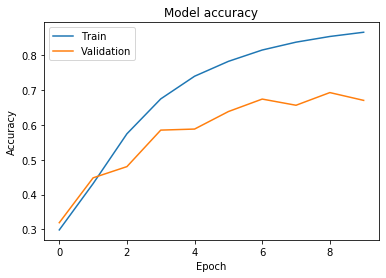

In [0]:
# Plot training & validation accuracy values
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

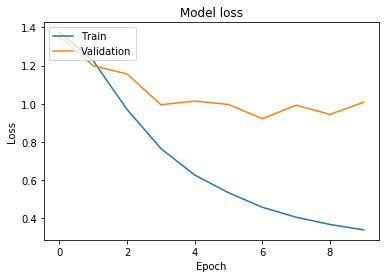

In [0]:
# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [0]:
plot_model(model5, to_file='cnn_model5.png')

In [0]:
units = 320
#cnn2 layer
sequence_input = Input(shape=(max_length,), dtype='int32')
embedded_sequences = Embedding(vocab_size, embedding_dim, input_length=max_length)(sequence_input)
output = Conv1D(units, kernel_size=26, padding='same', activation='relu')(embedded_sequences)
output = MaxPooling1D(pool_size=13, padding='same')(output)
output = BatchNormalization()(output)
output = Activation('relu')(output)
output = Dropout(0.5)(output)
output = Conv1D(units, kernel_size=26, padding='same', activation='relu')(output)
output = MaxPooling1D(pool_size=13, strides=13, padding='same')(output)
output = BatchNormalization()(output)
output = Activation('relu')(output)
output = Dropout(0.2)(output)

#Attention Layer
# output = Att1_layer(output, units)

#cnn2 layer
output = Flatten()(output)
output = Dense(6)(output)
output = Dense(4)(output)
output = Activation('softmax')(output)


model6 = Model(inputs=sequence_input, outputs=output)
model6.summary()

Model: "model_16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_24 (InputLayer)        (None, 120)               0         
_________________________________________________________________
embedding_24 (Embedding)     (None, 120, 60)           600000    
_________________________________________________________________
conv1d_35 (Conv1D)           (None, 120, 320)          499520    
_________________________________________________________________
max_pooling1d_25 (MaxPooling (None, 10, 320)           0         
_________________________________________________________________
batch_normalization_23 (Batc (None, 10, 320)           1280      
_________________________________________________________________
activation_34 (Activation)   (None, 10, 320)           0         
_________________________________________________________________
dropout_38 (Dropout)         (None, 10, 320)           0  

In [0]:
model6.compile(loss='categorical_crossentropy', optimizer = 'Adam' , metrics=['accuracy'])

In [0]:
history = model6.fit(train_data, train_labels, batch_size = 512, validation_data = (valid_data, valid_labels), epochs = 10, verbose = 1 )

Train on 83101 samples, validate on 35615 samples
Epoch 1/10
83101/83101 [==============================] - 14s 172us/step - loss: 1.4571 - acc: 0.2778 - val_loss: 1.3806 - val_acc: 0.2878
Epoch 2/10
83101/83101 [==============================] - 11s 130us/step - loss: 1.3752 - acc: 0.3109 - val_loss: 1.3415 - val_acc: 0.3150
Epoch 3/10
83101/83101 [==============================] - 11s 130us/step - loss: 1.3197 - acc: 0.3461 - val_loss: 1.3325 - val_acc: 0.3262
Epoch 4/10
83101/83101 [==============================] - 11s 131us/step - loss: 1.2656 - acc: 0.3781 - val_loss: 1.4102 - val_acc: 0.3362
Epoch 5/10
83101/83101 [==============================] - 11s 130us/step - loss: 1.2161 - acc: 0.4103 - val_loss: 1.2721 - val_acc: 0.3726
Epoch 6/10
83101/83101 [==============================] - 11s 130us/step - loss: 1.1715 - acc: 0.4357 - val_loss: 1.2182 - val_acc: 0.4151
Epoch 7/10
83101/83101 [==============================] - 11s 132us/step - loss: 1.1284 - acc: 0.4607 - val_loss: 1.

In [0]:
results = model6.evaluate(valid_data, valid_labels)

35615/35615 [==============================] - 8s 215us/step


In [0]:
print('Test accuracy: ', results[1])

Test accuracy:  0.7170293415745841


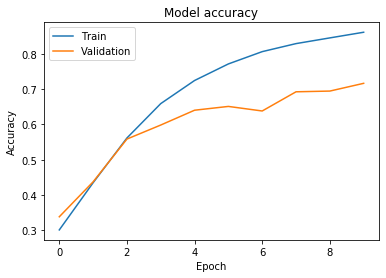

In [0]:
# Plot training & validation accuracy values
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

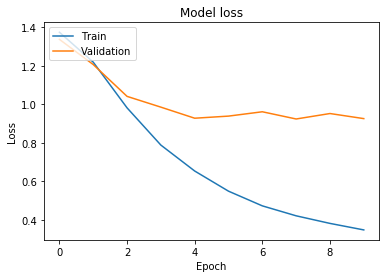

In [0]:
# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [0]:
plot_model(model6, to_file='cnn_model6.png')